In [2]:
#IJulia.load("../examples/vlasov-hmf-gauss.jl")

In [62]:
using LinearAlgebra, BenchmarkTools, QuadGK, Roots, FFTW

In [63]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [64]:
" Compute M₀ by solving F(m) = 0 "
function mag(β, mass)
    
    F(m) = begin
        g(x, n, m) = (1 / π) * (exp(β * m * cos(x)) * cos(n * x))
        bessel0(x) = g(x, 0, m) 
        bessel1(x) = g(x, 1, m)
        mass * quadgk(bessel1, 0, π)[1] / quadgk(bessel0, 0, π)[1] - m
    end
    
    find_zero(F, (0, mass))
end

mag

In [82]:
using Splittings
function Norm(f::Array{Float64,2}, meshx::UniformMesh, meshv::UniformMesh)
   return meshx.dx * sum(meshv.dx * sum(real(f), dims=1))
end

Norm (generic function with 2 methods)

In [83]:
"""

    Compute the electric hamiltonian mean field from a 2D distribution function

"""
function hmf_poisson(f::Array{Float64,2}, meshx::UniformMesh, meshv::UniformMesh)

    nx = meshx.nx
    rho = meshv.dx * sum(f, dims=2)
    kernel = zeros(Float64, nx)
    kernel[2] = π / (meshx.xmax - meshx.xmin) 
    real(ifft(1im * fft(rho) .* kernel * 4π ))

end

hmf_poisson

In [84]:
function advection_x!(meshx::UniformMesh, 
                      meshv::UniformMesh,
                      f::Array{Float64,2},
                      dt::Float64)
    for j in 1:meshv.nx
        alpha = meshv.x[j] * dt
        f[:,j] .= Splittings.interpolate(3, f[:,j], meshx.dx, alpha)
    end
end

advection_x! (generic function with 1 method)

In [85]:
function advection_v!(meshx::UniformMesh, 
                      meshv::UniformMesh,
                      f::Array{Float64,2},
                      ex::Array{Float64},
                      dt::Float64)
    for i in 1:meshx.nx
        alpha = ex[i] * dt
        f[i,:] .= Splittings.interpolate(3, f[i,:], meshv.dx,  alpha)
    end
end

advection_v! (generic function with 1 method)

In [104]:
function vlasov_hmf_gauss(nbiter = 10000, deltat = 0.1)

    mass = 1.0
    T = 0.1
    meshx = UniformMesh(-π, π, 64)
    meshv = UniformMesh(-8, 8, 64)
    
    nx = meshv.nx
    nv = meshv.nx
    x, v = meshx.x, meshv.x
    ϵ = 0.1
    
    b = 1 / T
    m = mag(b, mass)
   
    w   = sqrt(m)
    f   = zeros(Float64, (nx,nv))
    for i=1:nx, j=1:nv
        f[i,j] = exp(-b * ((v[j]^2 / 2) - m * cos(x[i])))
    end
    a   = mass / Norm(f, meshx, meshv)
    
    for i=1:nx, j=1:nv
        f[i,j] =  a * exp(-b * (((v[j]^2) / 2) - m * cos(x[i]))) * (1 + ϵ * cos(x[i]))
    end
    
    ex = hmf_poisson(f, meshx, meshv)
    test = copy(f)
    T = zeros(Float64, nbiter)
    nrj = Float64[]
    for n in 1:nbiter
    
        """Computation of the desired gamma for f at time n*deltat"""
        for i=1:nx, j=1:nv
            test[i,j] = f[i,j] * cos(x[i])
        end

        gamma1 = Norm(test, meshx, meshv)
        T[n] = gamma1
    
        """Vlasov-HMF Strang"""
        advection_x!(meshx, meshv, f, deltat / 2)
        ex = hmf_poisson(f, meshx, meshv)
        advection_v!(meshx, meshv, f, ex, deltat)
        advection_x!(meshx, meshv, f, deltat / 2)
    
    end
    
    
    #Substracting from gamma its long time average
    final = copy(f)
    for i=1:nx, j=1:nv
        final[i,j] = f[i,j] * cos(x[i])
    end
    Gamma1 = Norm(final, meshx, meshv)
    for n in 1:nbiter
        T[n] = T[n] - Gamma1
    end
    
    range(0., stop=nbiter*deltat, length=nbiter), abs.(T)
    
end 

vlasov_hmf_gauss (generic function with 3 methods)

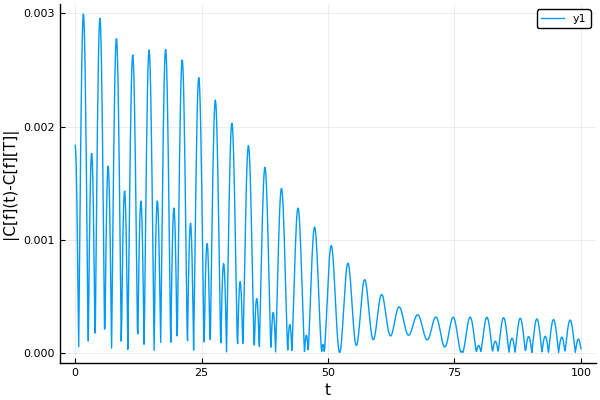

In [109]:
nbiter = 1000
deltat = 0.1
t, T = vlasov_hmf_gauss(nbiter, deltat)

plot(t, T, 
    xlabel = "t",
    ylabel = "|C[f](t)-C[f][T]|")